In [1]:
import numpy as np
import torch

seed = 42
#random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [2]:
from torchvision import models
from torch.hub import load_state_dict_from_url


class ResNet101(models.ResNet):
    def __init__(self, num_classes=1000, pretrained=True, **kwargs):
        super().__init__(block=models.resnet.Bottleneck, layers=[3, 4, 23, 3], num_classes=num_classes, **kwargs)
        if pretrained:
            state_dict = load_state_dict_from_url(models.resnet.model_urls['resnet101'], progress=True)
            self.load_state_dict(state_dict)


    def _forward_impl(self, x):
        # Standard forward for resnet
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Notice there is no forward pass through the original classifier.
        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        return x

In [3]:
from torchvision import transforms
import random
from PIL import Image, ImageFile
import os

class TwitterDataset(torch.utils.data.Dataset):
    def __init__(self, data_path):
        if not os.path.exists(data_path):
            raise Exception(data_path + ' does not exist!')

        self.data = []

        folders = os.listdir(data_path)
        for folder in folders:

            full_path = os.path.join(data_path, folder)
            images = os.listdir(full_path)

            current_data = [os.path.join(full_path, image) for image in images]
            self.data += current_data

        #num_images = min(num_images, len(self.data))
        #self.data = random.sample(self.data) # only use num_images images

        # We use the transforms described in official PyTorch ResNet inference example:
        # https://pytorch.org/hub/pytorch_vision_resnet/.
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.transform_grayscale = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        image = Image.open(image_path).convert('RGB')
        try:
            image = self.transform(image)
        except RuntimeError:
            # Some grayscale images cause an error in normalize.
            image = self.transform_grayscale(image)
        return {'image': image, 'image_path': image_path}


In [4]:
def collate_skip_empty(batch):
    batch = [sample for sample in batch if sample] # check that sample is not None
    return torch.utils.data.dataloader.default_collate(batch)

In [39]:
from pathlib import Path
import matplotlib.pyplot as plt
import pickle


image_path = os.path.join(Path(os.getcwd()).parent, 'data\\raw\\no_dupes')
ds = TwitterDataset(image_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


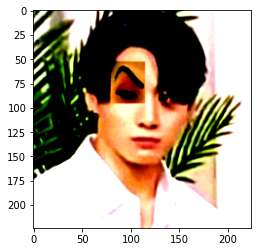

In [41]:
plt.imshow(ds.__getitem__(600)["image"].moveaxis(0,-1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


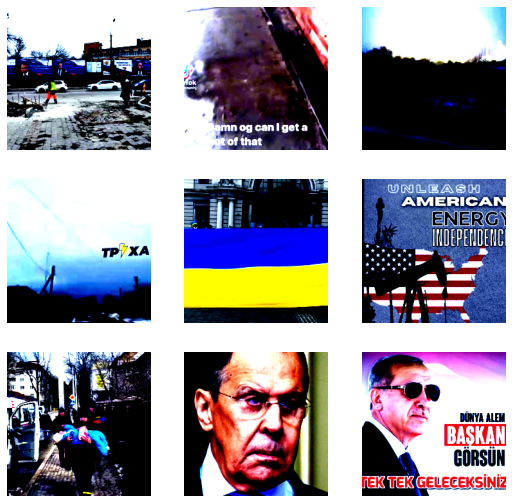

In [42]:
figure = plt.figure(figsize=(9,9))
for i in range(9):
    random_int = random.randint(0, len(ds)) - 1
    plt.subplot(3,3,i+1)
    plt.imshow(ds.__getitem__(random_int)["image"].moveaxis(0,-1))
    plt.axis('off')

In [43]:
import argparse
from tqdm import tqdm
import cv2
from sklearn.manifold import TSNE

In [44]:
def get_features(image_path, batch):
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    # initialize our implementation of ResNet
    model = ResNet101(pretrained=True)
    model.eval()
    model.to(device)

    # read the dataset and initialize the data loader
    ds = TwitterDataset(image_path)
    dataloader = torch.utils.data.DataLoader(ds, batch_size=batch, shuffle=True)

    # we'll store the features as NumPy array of size num_images x feature_size
    features = None

    # we'll also store the image labels and paths to visualize them later
    image_paths = []

    for batch in tqdm(dataloader, desc='Running the model inference'):
        images = batch['image'].to(device)
        image_paths += batch['image_path']

        with torch.no_grad():
            output = model.forward(images)

        current_features = output.cpu().numpy()
        if features is not None:
            features = np.concatenate((features, current_features))
        else:
            features = current_features

    return features, image_paths

In [45]:
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range


def scale_image(image, max_image_size):
    image_height, image_width, _ = image.shape

    scale = max(1, image_width / max_image_size, image_height / max_image_size)
    image_width = int(image_width / scale)
    image_height = int(image_height / scale)

    image = cv2.resize(image, (image_width, image_height))
    return image

In [46]:
def compute_plot_coordinates(image, x, y, image_centers_area_size, offset):
    image_height, image_width, _ = image.shape

    # compute the image center coordinates on the plot
    center_x = int(image_centers_area_size * x) + offset

    # in matplotlib, the y axis is directed upward
    # to have the same here, we need to mirror the y coordinate
    center_y = int(image_centers_area_size * (1 - y)) + offset

    # knowing the image center, compute the coordinates of the top left and bottom right corner
    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)

    br_x = tl_x + image_width
    br_y = tl_y + image_height

    return tl_x, tl_y, br_x, br_y

In [64]:
def visualize_tsne_images(tx, ty, images, plot_size=1000, max_image_size=100):
    # we'll put the image centers in the central area of the plot
    # and use offsets to make sure the images fit the plot
    offset = max_image_size // 2
    image_centers_area_size = plot_size - 2 * offset

    tsne_plot = 255 * np.ones((plot_size, plot_size, 3), np.uint8)

    # now we'll put a small copy of every image to its corresponding T-SNE coordinate
    for image_path, x, y in tqdm(
            zip(images, tx, ty),
            desc='Building the T-SNE plot',
            total=len(images)
    ):
        image = cv2.imread(image_path)

        # scale the image to put it to the plot
        image = scale_image(image, max_image_size)


        # compute the coordinates of the image on the scaled plot visualization
        tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, image_centers_area_size, offset)

        # put the image to its TSNE coordinates using numpy subarray indices
        tsne_plot[tl_y:br_y, tl_x:br_x, :] = image
    plt.figure(figsize=(24,24))
    plt.imshow(tsne_plot[:, :, ::-1])
    plt.savefig('tsne_image.png', bbox_inches='tight',dpi=250)
    plt.show()


In [48]:
def visualize_tsne(tsne, images, plot_size=1000, max_image_size=100):
    # extract x and y coordinates representing the positions of the images on T-SNE plot
    tx = tsne[:, 0]
    ty = tsne[:, 1]

    # scale and move the coordinates so they fit [0; 1] range
    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)

    # visualize the plot: samples as colored points
    #visualize_tsne_points(tx, ty, labels)

    # visualize the plot: samples as images
    visualize_tsne_images(tx, ty, images, plot_size=plot_size, max_image_size=max_image_size)


In [49]:
batch = 10
features, image_paths = get_features(image_path, batch)

Running the model inference:  61%|██████    | 119/195 [04:39<02:53,  2.29s/it]C:\Users\ati\.conda\envs\SoMe\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Running the model inference: 100%|██████████| 195/195 [08:08<00:00,  2.50s/it]


In [50]:
tsne = TSNE(n_components=2).fit_transform(features)

C:\Users\ati\.conda\envs\SoMe\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\ati\.conda\envs\SoMe\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Building the T-SNE plot: 100%|██████████| 1946/1946 [00:24<00:00, 79.54it/s]


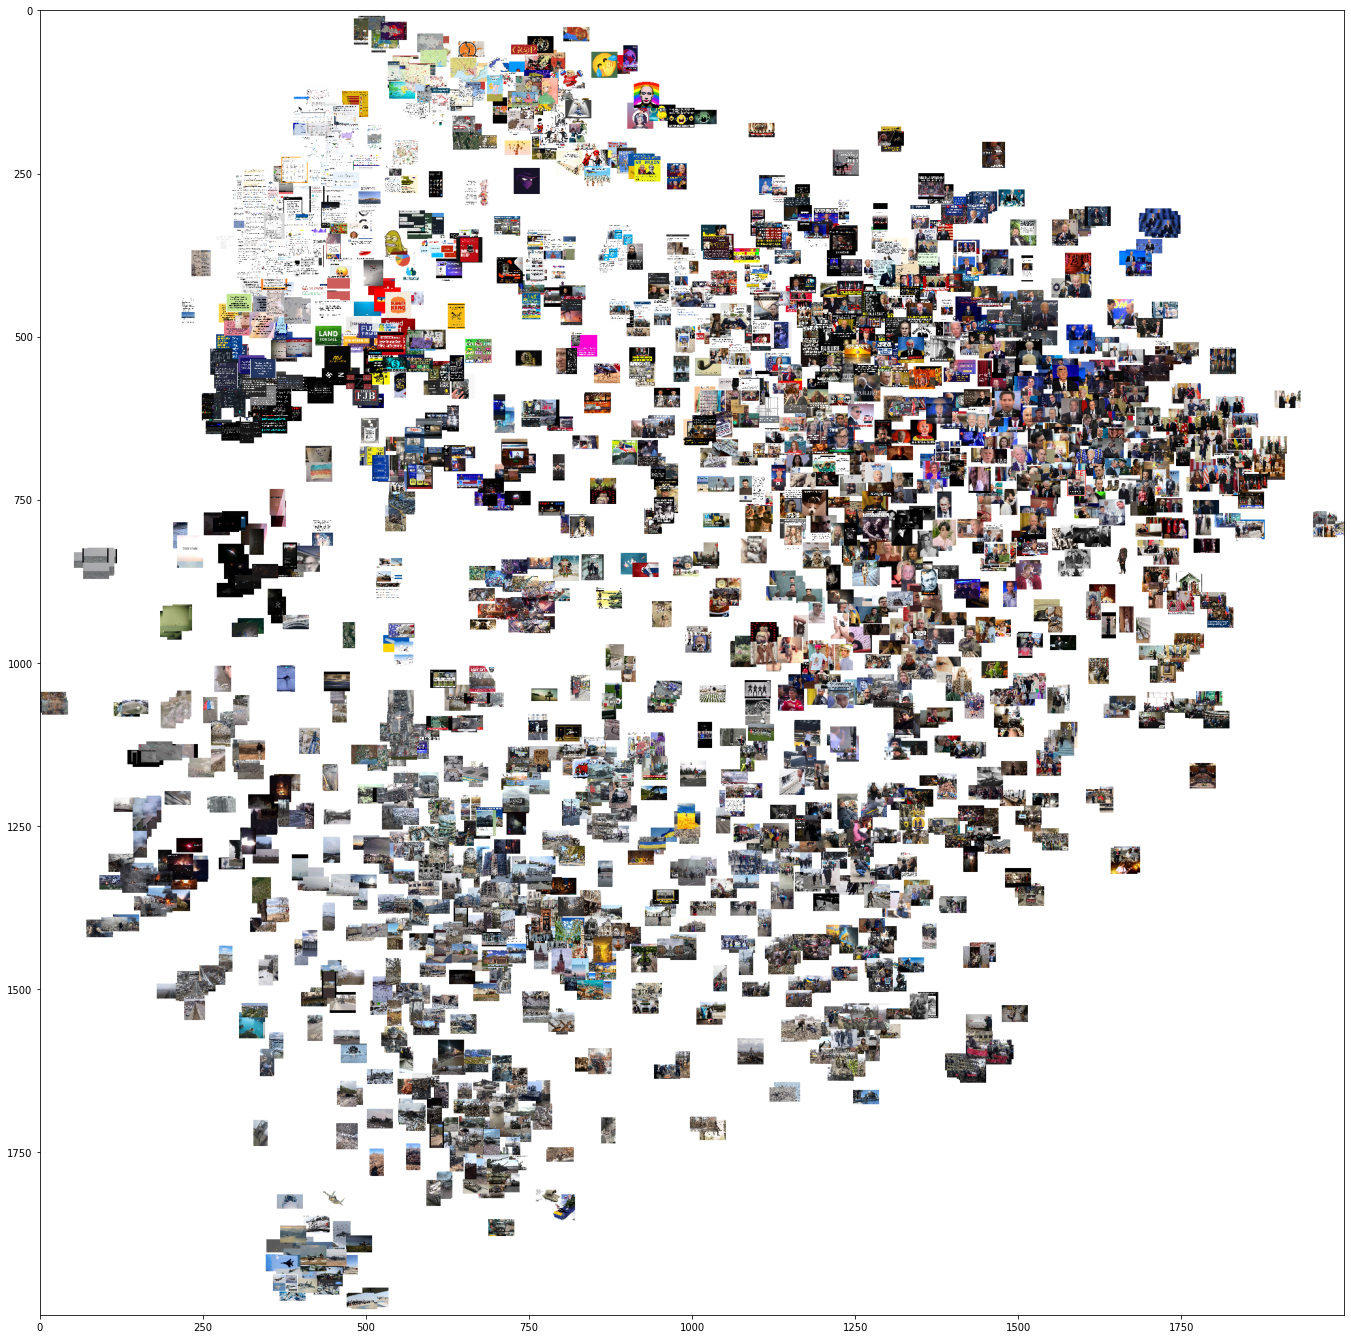

In [66]:
%matplotlib inline
visualize_tsne(tsne, image_paths, plot_size=2000, max_image_size=40)